In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from bci_dataset import BCIDataset

from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes, WindowOperations, NoiseTypes

from sklearn import metrics

from tsai.models.RNN_FCN import MLSTM_FCN
from tsai.models.FCN import FCN
from tsai.models.FCNPlus import FCNPlus
from tsai.models.TCN import TCN

from torchvision.models import convnext_small
from torchvision.models.convnext import Conv2dNormActivation

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda


In [3]:
train_dataset = BCIDataset('data/train', hz=256, seconds=1, overlap=0.25, one_hot=True)
test_dataset = BCIDataset('data/test', hz=256, seconds=1, overlap=0.25, one_hot=True)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [14]:
left = 0
center = 0
right = 0
for batch in train_dataset:
    c = torch.argmax(batch['targets'])
    if c.item() == 0:
        left += 1
    elif c.item() == 1:
        center += 1
    elif c.item() == 2:
        right += 1

print(f'left: {left}, center: {center}, right: {right}')

left: 219, center: 281, right: 221


In [ ]:
data = train_dataset[30]
eeg_data = data['inputs'][1]
print(torch.argmax(data['targets']).item())

eeg_data_yflip = np.flipud(eeg_data)
plt.imshow(eeg_data_yflip, extent=[-1, 1, 1, 256//8], cmap='PRGn', aspect='auto',
           vmax=abs(eeg_data).max(), vmin=-abs(eeg_data).max())
plt.show()

tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])


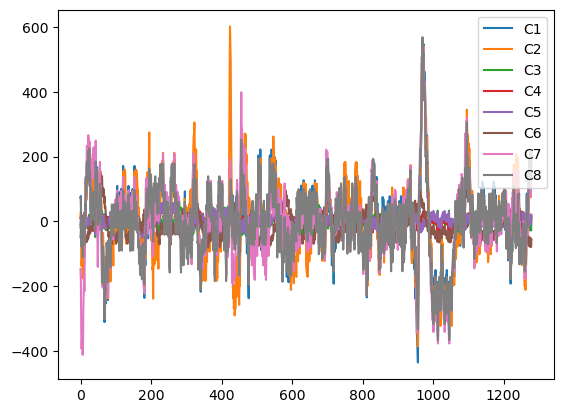

In [10]:
sample = 10
data = train_dataset[0:sample]
eeg_data = np.empty((8, sample*data['inputs'][0].shape[1]))
temp = data['inputs']
for i in range(sample):
    eeg_data[:, i*temp[0].shape[1]:(i+1)*temp[0].shape[1]] = temp[i]

print(data['targets'])
for i, channel in enumerate(eeg_data):
    plt.plot(channel, label = f"C{i+1}")
plt.legend()
plt.show()

In [17]:
# model = MLSTM_FCN(c_in=8, c_out=3, seq_len=32, se=16)
model = FCN(c_in=8, c_out=3)
# model = FCNPlus(c_in=8, c_out=3)
# model = TCN(c_in=8, c_out=3)

# model = convnext_small(num_classes=3, weights=None)
# model.features[0][0] = nn.Conv2d(8, 96, kernel_size=(4, 4), stride=(4, 4))

model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.0001)
loss_function = nn.SmoothL1Loss()
# loss_function = nn.CrossEntropyLoss()

In [18]:
def fwd_pass(inputs, targets, train=False):
  inputs = inputs.to(device)
  targets = targets.to(device)

  if train:
    model.zero_grad()
  
  outputs = model(inputs)
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, targets)]
  acc = matches.count(True) / len(matches)
  
  loss = loss_function(outputs, targets)

  if train:
    loss.backward()
    optimizer.step()
  
  return acc, loss

In [19]:
now = datetime.now()
dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")
writer = SummaryWriter(f'runs/BCI_{dt_string}')

lowest_loss_epoch = 0
lowest_loss = 1000

EPOCHS = 200
global_step = 0
progress_bar = tqdm(total=EPOCHS)
for epoch in range(EPOCHS):
    # progress_bar = tqdm(total=len(train_dataloader))
    progress_bar.set_description(f"Epoch {epoch + 1}/{EPOCHS}")
    progress_bar.update(1)
    
    for step, batch in enumerate(train_dataloader):
        inputs = batch['inputs']
        targets = batch['targets']
        
        acc, loss = fwd_pass(inputs, targets, train=True)
        loss = loss.detach().item()
        
        # progress_bar.update(1)
        logs = {"loss": loss, "accuracy": acc, "step": global_step}
        progress_bar.set_postfix(**logs)
        
        writer.add_scalar('Loss/train', loss, global_step)
        writer.add_scalar('Accuracy/train', acc, global_step)
        
        
        global_step += 1
        
    
    test_acc_list = []
    test_loss_list = []
    for batch in test_dataloader:
        inputs = batch['inputs']
        targets = batch['targets']
        
        test_acc, test_loss = fwd_pass(inputs, targets, train=False)
        
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss.detach().item())
    
    test_acc = np.mean(test_acc_list)
    test_loss = np.mean(test_loss_list)
    
    if test_loss < lowest_loss:
        lowest_loss_epoch = epoch + 1
        lowest_loss = test_loss
        torch.save(model.state_dict(), f"models/model_{epoch + 1}.pth")
    
    writer.add_scalar('Loss/test', test_loss, global_step)
    writer.add_scalar('Accuracy/test', test_acc, global_step)
    
    if (epoch + 1) % 5 == 0 or epoch + 1 == EPOCHS:
        torch.save(model.state_dict(), f"models/model_{epoch + 1}.pth")

  0%|          | 0/200 [00:00<?, ?it/s]

In [11]:
# print(f"Lowest loss: {lowest_loss_epoch}")
# model.load_state_dict(torch.load(f'models/model_{lowest_loss_epoch}.pth'))
model.load_state_dict(torch.load(f'models/model_70.pth'))

inputs = test_dataset[:]['inputs'].to(device)
targets = test_dataset[:]['targets']

with torch.no_grad():
    outputs = model(inputs)

outputs = torch.argmax(outputs, dim=1).cpu().numpy()
targets = torch.argmax(targets, dim=1).cpu().numpy()

cm = metrics.confusion_matrix(targets, outputs, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Nothing', 'Right'])
disp.plot(cmap=plt.cm.Oranges)

NameError: name 'model' is not defined